## Seminar and homework (10 points total)

Today we shall compose encoder-decoder neural networks and apply them to the task of machine translation.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_


Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts

## Our task: machine translation

We gonna try our encoder-decoder models on russian to english machine translation problem. More specifically, we'll translate hotel and hostel descriptions. This task shows the scale of machine translation while not requiring you to train your model for weeks if you don't use GPU.

Before we get to the architecture, there's some preprocessing to be done. ~~Go tokenize~~ Alright, this time we've done preprocessing for you. As usual, the data will be tokenized with WordPunctTokenizer.

However, there's one more thing to do. Our data lines contain unique rare words. If we operate on a word level, we will have to deal with large vocabulary size. If instead we use character-level models, it would take lots of iterations to process a sequence. This time we're gonna pick something inbetween.

One popular approach is called [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) aka __BPE__. The algorithm starts with a character-level tokenization and then iteratively merges most frequent pairs for N iterations. This results in frequent words being merged into a single token and rare words split into syllables or even characters.



In [ ]:
#!pip3 install torch>=1.3.0
#!pip3 install subword-nmt &> log
#!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
#!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py -O vocab.py
# thanks to tilda and deephack teams for the data, Dmitry Emelyanenko for the code :)

In [1]:
!which pip

/usr/local/bin/pip


In [ ]:
#!pip install subword-nmt

In [2]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from vocab import Vocab

from IPython.display import clear_output
from tqdm import tqdm, trange

In [3]:
tokenizer = WordPunctTokenizer()

def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w', encoding="utf-8") as f_src, open('train.ru', 'w', encoding="utf-8") as f_dst:
    for line in open('data.txt', encoding="utf-8"):
        #print(line)
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang, encoding="utf-8"), open('bpe_rules.' + lang, 'w', encoding="utf-8"), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang, encoding="utf-8"))
    
    with open('train.bpe.' + lang, 'w', encoding="utf-8") as f_out:
        for line in open('train.' + lang, encoding="utf-8"):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into words.

In [4]:
data_inp = np.array(open('./train.bpe.ru', encoding="utf-8").read().split('\n'))
data_out = np.array(open('./train.bpe.en', encoding="utf-8").read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [ ]:
data_inp

In [5]:
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [6]:
# Here's how you cast lines into ids and backwards.
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


Draw source and translation length distributions to estimate the scope of the task.

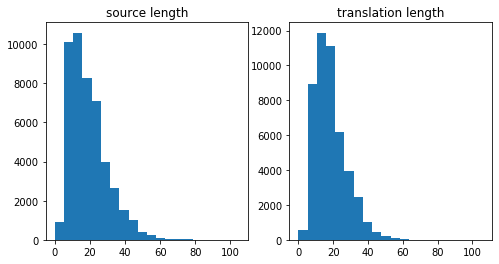

In [7]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### Encoder-decoder model

The code below contains a template for a simple encoder-decoder model: single GRU encoder/decoder, no attention or anything. This model is implemented for you as a reference and a baseline for your homework assignment.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [9]:
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_ids.shape
[batch_ids]

[tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
         [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
         [   0, 6030, 2083,   29,    1,    1,    1,    1],
         [   0, 4927, 1870,   29,    1,    1,    1,    1],
         [   0, 5549, 1453,   27,  592,   29,    1,    1]])]

In [10]:
def create_sentence(inp, voc):
    mystring = " "
    for i in voc.to_lines(inp):
        mystring+=i
    return mystring

print(len(inp_voc))
print(len(out_voc))
#inp_voc.bos_ix

8048
7801


In [14]:
torch.cuda.empty_cache()

In [11]:
dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

print("input batch: ", dummy_inp_tokens.shape)
print("\ninput: ", dummy_inp_tokens)
print("\noutput: ", dummy_out_tokens.shape)

print("\n", create_sentence(dummy_inp_tokens,inp_voc))
print(create_sentence(dummy_out_tokens, out_voc))

input batch:  torch.Size([5, 8])

input:  tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]], device='cuda:0')

output:  torch.Size([5, 7])

  гостевой дом r .до афин — 20 км .работает боулинг .оборудован балкон .подключен wi - fi .
 the hotel st .wifi is free .each has a tv .parking is free .parking is free .


In [12]:
my_model = BasicModel(inp_voc, out_voc).to(device)
h0_state, enc_in = my_model.encode(dummy_inp_tokens)
h0_state = h0_state[0].to("cpu")

enc_in = enc_in.to("cpu")
print(enc_in.shape)
print(h0_state.shape)

NameError: name 'BasicModel' is not defined

In [13]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__() # initialize base class to track sub-layers, parameters, etc.

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)     # encoder possible tokens
        self.emb_out = nn.Embedding(len(out_voc), emb_size)     # decocder possible tokens
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)    # ?
        self.dec0 = nn.GRUCell(emb_size, hid_size)        
        self.logits = nn.Linear(hid_size, len(out_voc))   
        
    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)    # create embedding
        #print("\nembedded batch",  inp_emb.shape)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)  # h_next, h_last
        #print("\nh_next: ", enc_seq.shape)
        #print("\nh_last: ", last_state_but_not_really.shape)
        # enc_seq: [batch, time(max_len), hid_size], last_state: [batch, hid_size]
        
        # note: last_state is not _actually_ last because of padding, let's find the real last_state   || why!!!
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]   # new h_last
        #print("\nfinal h_last: ", last_state.shape)
        # ^-- shape: [batch_size, hid_size]
        
        dec_start = self.dec_start(last_state)  # dec_start_linear * h_last
        #print("\ndecoder start", dec_start.shape)
        #return [dec_start], enc_seq
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]  # encode returns list
        
        out_emb = self.emb_out(prev_tokens)    # make embedding
        #print("\noutput emb", out_emb.shape)
        
        h_next = self.dec0(out_emb, prev_gru0_state)    # calculate next hidden state
        #print("\nh_next", h_next.shape)
        
        output_logits = self.logits(h_next)             # calculaet logits of next hidden state
        #print("\noutput_logits", output_logits.shape)
         
        return [h_next], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state
        
        #print("\n----------Decoder Main---------------")
        #print("encoder pass", initial_state[0].shape)
        #print("out tokens",out_tokens.shape)
        
        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        
        
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        
        #print("first_logits", onehot_bos.shape)
        
        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])    # claculate h_next + h_next_to_logits
            #print("\nstate len", len(state))
            logits_sequence.append(logits)                               # append
        return torch.stack(logits_sequence, dim=1)    

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, 
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
        
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        
        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        print("input text", inp_lines)
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        print("\ninp:", inp.shape)
        
        initial_state = self.encode(inp)
        
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [14]:
# debugging area
model = BasicModel(inp_voc, out_voc).to(device)

print("batch_size", dummy_inp_tokens.shape)
#print("\nembedding layer", model.emb_inp.weight.shape)
h0 = model.encode(dummy_inp_tokens)

#model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))
h1, logits1 = model.decode_step(h0, dummy_inp_tokens[:,0])
h2, logits2 = model.decode_step(h1, dummy_inp_tokens[:,1])

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

batch_size torch.Size([5, 8])


In [15]:
inp = dev_inp[0:1]
#print(inp)

translation, states = model.translate_lines(inp, max_len=50)
print("\ntranslation", translation)
print("\nstates", states[0][0].shape)

input text ['в распоряжении гостей общая кухня и общая гостиная .']

inp: torch.Size([1, 11])

translation ['zon@@ iii forte ener@@ azzo у@@ gage dan@@ azur plas@@ attic nin stal@@ ul energy catalunya gnano tor@@ mina agen rochelle rochelle track are ral bukov@@ galo@@ gena reis aa neighbor@@ statue ros@@ check spain cellar stal@@ bur@@ alpine apartament@@ ē@@ tions zhen means nic@@ wood@@ struc@@ dame dame cuisine']

states torch.Size([1, 128])


In [16]:
dummy_translations, dummy_states = model.translate_lines(train_inp[1:2], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

input text ['кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .']

inp: torch.Size([1, 15])
Translations without training:
zon@@ iii forte ener@@ azzo у@@ gage dan@@ azur plas@@ attic nin stal@@ ul energy catalunya gnano tor@@ mina agen rochelle rochelle track are ral


### Training loss (2 points)

Our training objective is almost the same as it was for neural language models:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but excluding PAD.

In [17]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]   --> "" compute a boolean mask that equals "1" until first EOS (including that EOS) """
    #print("\nmask", mask.shape)
    
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)   # 5, 7, 7801
    #print("\ntargets_1hot", targets_1hot.shape)
    
    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)
    #print("\nlogits of batch", logits_seq.shape)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = F.log_softmax(logits_seq, dim=-1)
    
    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    #print("\ncorrect logp", logp_out.shape)
    # ^-- this will select the probability of the actual next token.

    
    logp_out = torch.mul(logp_out, mask) # apply mask
    loss = -logp_out.mean()
    # Note: you can compute loss more efficiently using using F.cross_entropy

#     # average cross-entropy over tokens where mask == True
    return loss # average loss, scalar

In [18]:
print("input tokens", dummy_inp_tokens.shape)
print("output tokens", dummy_out_tokens.shape)

compute_loss(model, dummy_inp_tokens, dummy_out_tokens).item()

input tokens torch.Size([5, 8])
output tokens torch.Size([5, 7])


6.632195949554443

In [22]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(6.6757, device='cuda:0', grad_fn=<NegBackward>)


### Evaluation: BLEU

Machine translation is commonly evaluated with [BLEU](https://en.wikipedia.org/wiki/BLEU) score. This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

While BLEU [has many drawbacks](http://www.cs.jhu.edu/~ccb/publications/re-evaluating-the-role-of-bleu-in-mt-research.pdf), it still remains the most commonly used metric and one of the simplest to compute.

In [23]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    Note: if you're serious about reporting your results, use https://pypi.org/project/sacrebleu
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [24]:
compute_bleu(model, dev_inp, dev_out)

input text ['в распоряжении гостей общая кухня и общая гостиная .'
 'на территории виллы sh@@ eng@@ si hu@@ a@@ jing находится сад и терраса .'
 'расстояние от отеля li@@ bu@@ š@@ e до ближайшей станции метро ko@@ by@@ lis@@ y ( линия с ), от которой можно добраться до центрального железнодорожного вокзала праги и центра города , составляет 500 метров .'
 ...
 'в нескольких минутах ходьбы от гостевого дома fal@@ k@@ inn работают рестораны , бары и торговые центры .'
 'в некоторых из них есть терраса и / или балкон с видом на море .'
 'отель costa village обеспечи@@ вает круглосуточ@@ ную бе@@ зо@@ пас@@ ность .']

inp: torch.Size([3000, 106])


0.0017321456587414876

### Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [25]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BasicModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

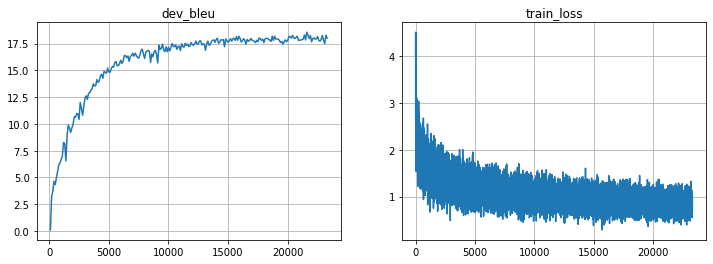

Mean loss=0.814


 93%|█████████▎| 23371/25000 [17:31<01:00, 26.83it/s]

KeyboardInterrupt: 

In [26]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    #print(step)
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)
    
    #print("input tokens", batch_inp.shape)
    #print("output tokens", batch_out.shape)
    
    #<YOUR CODE: training step using batch_inp and batch_out>
    
    #print("\nloss:", loss)
    
    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()
    
    
    metrics['train_loss'].append((step, loss_t.item()))
    
    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [ ]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

In [41]:
def train_model(model, opt, batch_size):
    #<YOUR CODE: training loop>
    metrics = {'train_loss': [], 'dev_bleu': [] }

    for _ in trange(25000):
        step = len(metrics['train_loss']) + 1
        
        batch_ix = np.random.randint(len(train_inp), size=batch_size)
        batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
        batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)
    
    
        #<YOUR CODE: training step using batch_inp and batch_out>
        loss_t = compute_loss(model, batch_inp, batch_out)
        #print("\nloss:", loss_t)
    
        loss_t.backward()
        opt.step()
        opt.zero_grad()
    
        metrics['train_loss'].append((step, loss_t.item()))
    
        if step % 100 == 0:
            metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))
        
            clear_output(True)
            plt.figure(figsize=(12,4))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()
            print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

# Homework code templates will appear here soon!

### Your Attention Required

In this section we want you to improve over the basic model by implementing a simple attention mechanism.

This is gonna be a two-parter: building the __attention layer__ and using it for an __attentive seq2seq model__.

### Attention layer (3 points)

Here you will have to implement a layer that computes a simple additive attention:

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Get probabilities from logits, 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can learn more about attention layers in the lecture slides or [from this post](https://distill.pub/2016/augmented-rnns/).

In [18]:
class RevisedAttentionLayer(nn.Module):  # dot product
    def __init__(self):
        """ A layer that computes additive attention response and weights """
        super().__init__()

    def forward(self, enc, dec, inp_mask):

        #inp_mask = ~inp_mask
        
        # Compute Attention Score logits 
        attn_scores = torch.bmm(enc, dec.unsqueeze(dim=-1))
        
        # Apply mask - if mask is 0, logits should be -inf or -1e9
        attn_scores =  attn_scores.masked_fill(~inp_mask.unsqueeze(dim=-1), -float('inf'))
        #print("/nattn_scores", attn_scores)
        
        # apply softmax 
        #attn_weights = F.log_softmax(final_attn_score, dim=1)
        attn_weights = attn_scores.softmax(dim=1)
        
        # Compute attention response using enc and probs
        attn_response = (attn_weights * enc).sum(dim=1)
    
        return attn_response, attn_weights

In [ ]:
my_mask = inp_voc.compute_mask(dummy_inp_tokens).to('cpu')
print("mask shape", my_mask.shape)
print(my_mask)

rev_attn_layer = RevisedAttentionLayer()

print(enc_in.shape)
print(h0_state.shape)

attn_res, attn_prob = rev_attn_layer(enc_in, h0_state, my_mask)
torch.as_tensor(attn_res).shape

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size, activ=torch.tanh):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.name = name
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity
        
        # create trainable paramteres like this:
        #self.<PARAMETER_NAME> = nn.Parameter(<INITIAL_VALUES>, requires_grad=True)
        
        self.linear_encoder = nn.Linear(enc_size, hid_size, bias=False)
        self.linear_decoder = nn.Linear(dec_size, hid_size, bias=False)
        self.linear_output = nn.Linear(hid_size, dec_size, bias=False)
        
        """
        self.linear_encoder = nn.Parameter(enc_size, 128, requires_grad=True)
        self.linear_decoder = nn.Parameter(dec_size, 128, requires_grad=True)
        self.linear_encoder = nn.Parameter(128, enc_size, requires_grad=True)
        """

    def forward(self, enc, dec, inp_mask=0):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size] -> [batch_size, 1, dec_size] -> [batch_size, ninp, enc_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
            
        1. dec.shape -> [batch_size, ninp, dec_size], enc.shape -> [batch_size, ninp, enc_size]
        2. #encoder -> reshape -> [batch_size*ninp, enc_size], decoder -> [batch_size * ninp, dec_size]
        3. Linear_encoder(encoder) -> [batch_size*ninp, 128], Linear_decoder(decoder) -> [batch_size*ninp, 128]
        4. -> nn.tanh(Linear_encoder(encoder)) = tanh_e
        5. tanh_e + Linear_decoder(decoder) = res_5
        6. linear_output(res_5) -> [batch_size*ninp, enc_size] -> reshape -> [batch_size, ninp, enc_size]
        7. enc -> [batch_size, ninp, enc_size], enc + linear_output(res_5)
        """
        
        # Compute Attention Weights
        encoder_w = self.linear_encoder(enc)  # [batch_size * max_len * enc_hidden] @ [enc_hidden, 128] = [batch_size, max_len, 128]
        print("\nenc_w: ", encoder_w.shape)
        #encoder_w = encoder_w.view(encoder_w.size(0), -1)
        #print("\nenc_w: ", encoder_w.shape)
        
        dec = torch.unsqueeze(dec, 1)
        decoder_w = self.linear_decoder(dec)  # [batch_size * dec_hidden] @ [dec_hidden, 128] = [batch_size, 128]
        print("\ndec_w: ", decoder_w.shape)

        # Compute logits
        attn_weights = self.linear_output(self.activ(encoder_w + decoder_w))
        print("\nattn_weights : ", attn_weights.shape)

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # attn_weights = torch.mul(attn_weights, inp_mask) + apply_mask(inp_mask)
        # You may need torch.where
        #<...>

        # Compute attention probabilities (softmax)
        probs = F.log_softmax(attn_weights, dim=-1)
        print("\nprobs : ", probs.shape)

        # Compute attention response using enc and probs
        attent = probs*enc
        print("attention", attent.shape)
        attent = torch.sum(attent, axis = 1)
        #attent = torch.sum(attent, axis = 0)
        print("atts_sum", attent.shape)

        return attent, probs

In [ ]:
attn_layer = AttentionLayer(name="simple_attention", enc_size=128, dec_size=128, hid_size=256)
#mask = inp_voc.compute_mask(dummy_inp_tokens).to("cpu")

print(enc_in.shape)
print(h0_state.shape)
#print(mask.shape)

attn, probs = attn_layer(enc_in, h0_state)
print("attn prob: ", probs.shape)
print("attn:", attn.shape)


### Seq2seq model with attention (3 points)

You can now use the attention layer to build a network. The simplest way to implement attention is to use it in decoder phase:
![img](https://i.imgur.com/6fKHlHb.png)
_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

On every step, use __previous__ decoder state to obtain attention response. Then feed concat this response to the inputs of next attention layer.

The key implementation detail here is __model state__. Put simply, you can add any tensor into the list of `encode` outputs. You will then have access to them at each `decode` step. This may include:
* Last RNN hidden states (as in basic model)
* The whole sequence of encoder outputs (to attend to) and mask
* Attention probabilities (to visualize)

_There are, of course, alternative ways to wire attention into your network and different kinds of attention. Take a look at [this](https://arxiv.org/abs/1609.08144), [this](https://arxiv.org/abs/1706.03762) and [this](https://arxiv.org/abs/1808.03867) for ideas. And for image captioning/im2latex there's [visual attention](https://arxiv.org/abs/1502.03044)_

In [38]:
class AttentionModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
    
        super().__init__() 

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)     # encoder possible tokens
        self.emb_out = nn.Embedding(len(out_voc), emb_size)     # decocder possible tokens
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)    
        self.dec0 = nn.GRUCell(emb_size, hid_size)        
        self.logits = nn.Linear(hid_size, len(out_voc))   
        
        self.attn_layer = RevisedAttentionLayer()
        self.converter = nn.Linear(hid_size * 2, hid_size, bias=False) 
        self.batch_norm = nn.BatchNorm1d(hid_size * 2)
        
        self.batch_norm1 = nn.BatchNorm1d(hid_size)
        self.batch_norm2 = nn.BatchNorm1d(hid_size)
        
        self.x1 = nn.Linear(hid_size, hid_size)
        self.x2 = nn.Linear(hid_size, hid_size)
        
        self.m = nn.Tanh()
        self.relu = nn.ReLU()
        
        
    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state, enc_seq, mask = self.encode(inp)
        return self.decode(initial_state, out, enc_seq, mask)


    def encode(self, inp, **flags):
        
        # create mask
        mask = inp_voc.compute_mask(inp) 
        
        # create emedding
        inp_emb = self.emb_inp(inp) 
    
        batch_size = inp.shape[0]
        
        # create enc_sequance + last hidden state
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)  # h_next, h_last
        
        # note: last_state is not _actually_ last because of padding, let's find the real last_state   || why!!!
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]   # new h_last
        
        #pass last hidden state to decoder
        dec_start = self.dec_start(last_state) 
       
        return [dec_start], enc_seq, mask
        

    def decode_step(self, prev_state, prev_tokens, **flags):
        
        prev_gru0_state = prev_state[0]  # encode returns list
        
        out_emb = self.emb_out(prev_tokens)    # make embedding
        
        h_next = self.dec0(out_emb, prev_gru0_state)    # calculate next hidden state
        
        output_logits = self.logits(h_next)             # calculaet logits of next hidden state
         
        return [h_next], output_logits

    def decode(self, state, out_tokens, enc_seq, mask, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        
        batch_size = out_tokens.shape[0]
        
        noise = torch.ones(state[0].shape[0], state[0].shape[1]).to(device)
        
        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        
        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            
            state = state[0]
            attn, _ = self.attn_layer(enc_seq, state, mask) 
           
            # convert to [batxh_size x hid_size]  -->
            state = self.relu(self.x1(state))
            attn =  self.relu(self.x2(attn))
            
            state = torch.cat((state, attn), 1)
            # state = self.batch_norm(state)
            state = self.m(self.converter(state))
            #print("new_state_convert", out_tokens[:, i].shape)
            
            state, logits = self.decode_step([state], out_tokens[:, i])  
            logits_sequence.append(logits)                               
        return torch.stack(logits_sequence, dim=1)    

    def decode_inference(self, initial_state, enc_seq, mask, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        
        state = initial_state    # add attention
        #m = nn.Tanh()
        
        
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, 
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            attn, _ = self.attn_layer(enc_seq, state[0], mask)
            
            state = self.relu(self.x1(state[0]))
            attn =  self.relu(self.x2(attn))
            
            #state = torch.cat((state[0], attn), 1)
            state = torch.cat((state, attn), 1)
            state = self.m(self.converter(state))
            
            state, logits = self.decode_step([state], outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        
        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        print("input text", inp_lines)
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        print("\ninp:", inp.shape)
        
        initial_state, enc_seq, mask = self.encode(inp)
        
        out_ids, states = self.decode_inference(initial_state,enc_seq, mask, **kwargs)
        
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states



In [39]:
attn_model = AttentionModel(inp_voc, out_voc).to(device)

h0, enc_seq, mask = attn_model.encode(dummy_inp_tokens)

my_logits_seq = attn_model.decode(h0, dummy_out_tokens, enc_seq, mask)

logits_seq2 = attn_model(dummy_inp_tokens, dummy_out_tokens)
logits_seq2.shape

my_loss = compute_loss(attn_model, dummy_inp_tokens, dummy_out_tokens).item()
print("loss", my_loss)

dummy_translations, dummy_states = attn_model.translate_lines(train_inp[0:1], max_len=15)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

loss 6.715794086456299
input text ['на территории обустроена бесплатная частная парковка .']

inp: torch.Size([1, 9])
Translations without training:
pousada furnished cap fru@@ booking zagreb ically complex fly quality goro@@ rua pai@@ bot@@ z@@


### Training attentive model

Please reuse the infrastructure you've built for the regular model. I hope you didn't hard-code anything :)

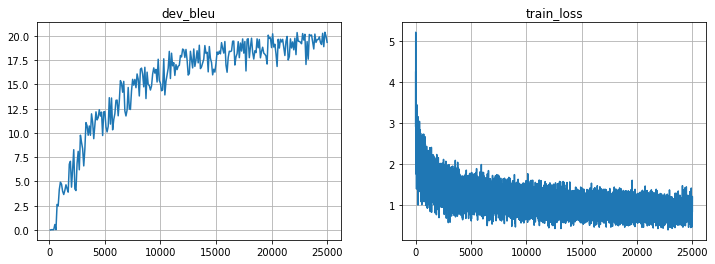

Mean loss=0.973




100%|██████████| 25000/25000 [27:12<00:00, 15.32it/s]


In [40]:
#<YOUR CODE: training loop>
metrics = {'train_loss': [], 'dev_bleu': [] }

#attn_model = AttentiveModel(inp_voc, out_voc, 5).to(device)
attn_model = AttentionModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(attn_model.parameters(), lr=1e-3)
batch_size = 32

for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    #print(step)
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)
    
    #print("input tokens", batch_inp.shape)
    #print("output tokens", batch_out.shape)
    
    #<YOUR CODE: training step using batch_inp and batch_out>
    loss_t = compute_loss(attn_model, batch_inp, batch_out)
    #print("\nloss:", loss_t)
    
    loss_t.backward()
    opt.step()
    opt.zero_grad()
    
    metrics['train_loss'].append((step, loss_t.item()))
    
    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(attn_model, dev_inp, dev_out)))
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)  

In [42]:
#<YOUR CODE: measure final BLEU>

dummy_translations, dummy_states = attn_model.translate_lines(train_inp[0:5], max_len=25)
#print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))


input text ['на территории обустроена бесплатная частная парковка .'
 'кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .'
 'отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .'
 'в распоряжении гостей также ванная комната с ванной или душем .'
 'апартаменты с 1 спальней o@@ as@@ i da el@@ io расположены в городе га@@ эта , в 1 , 2 км от регионального природного парка монте - орландо .']

inp: torch.Size([5, 31])
free private parking is available on site .
there are a lot of restaurants and bars .
the hotel is located in the centre of hvar , this hotel is located in the centre of hvar , this hotel is located in
the bathroom comes with a bath or shower .
apartment 3 is a self - catering accommodation located in gdańsk , 1 . 2 km from o2 arena .


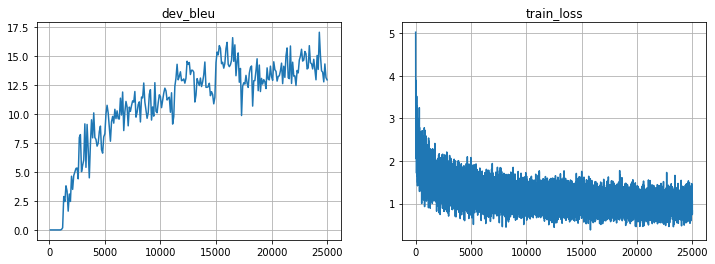

Mean loss=0.929


100%|██████████| 25000/25000 [31:24<00:00, 13.26it/s]


In [43]:
attn_model = AttentionModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(attn_model.parameters(), lr=1e-3)
batch_size = 32

train_model(attn_model, opt, batch_size)

### Visualizing model attention (2 points)

After training the attentive translation model, you can check it's sanity by visualizing its attention weights.

We provided you with a function that draws attention maps using [`Bokeh`](https://bokeh.pydata.org/en/latest/index.html). Once you managed to produce something better than random noise, please save at least 3 attention maps and __submit them to anytask__ alongside this notebook to get the max grade. Saving bokeh figures as __cell outputs is not enough!__ (TAs can't see saved bokeh figures in anytask). You can save bokeh images as screenshots or using this button:

![bokeh_panel](https://github.com/yandexdataschool/nlp_course/raw/2019/resources/bokeh_panel.png)

__Note:__ you're not locked into using bokeh. If you prefer a different visualization method, feel free to use that instead of bokeh.

In [43]:
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook, show
output_notebook()

def draw_attention(inp_line, translation, probs):
    """ An intentionally ambiguous function to visualize attention weights """
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    probs = probs[:len(trans_tokens), :len(inp_tokens)]
    probs = probs.tolist()
    print("probs", probs)
    
    fig = pl.figure(x_range=(0, len(inp_tokens)), y_range=(0, len(trans_tokens)),
                    x_axis_type=None, y_axis_type=None, tools=[])
    
    #print("probs", [probs[:-1]])
    
    #fig.image([probs[::-1]], 0, 0, len(inp_tokens), len(trans_tokens))
    fig.image([probs[:-1]], 0, 0, len(inp_tokens), len(trans_tokens))

    fig.add_layout(bm.LinearAxis(axis_label='source tokens'), 'above')
    fig.xaxis.ticker = np.arange(len(inp_tokens)) + 0.5
    fig.xaxis.major_label_overrides = dict(zip(np.arange(len(inp_tokens)) + 0.5, inp_tokens))
    fig.xaxis.major_label_orientation = 45

    fig.add_layout(bm.LinearAxis(axis_label='translation tokens'), 'left')
    fig.yaxis.ticker = np.arange(len(trans_tokens)) + 0.5
    fig.yaxis.major_label_overrides = dict(zip(np.arange(len(trans_tokens)) + 0.5, trans_tokens[::-1]))

    show(fig)

Loading BokehJS ...

## Generate Text

In [46]:
inp = train_inp[5:10]

inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

#mask = inp_voc.compute_mask(inp_tokens).to('cpu')


h0_state, enc_in, mask = attn_model.encode(inp_tokens)
h0_state = h0_state[0].to(device)
enc_in = enc_in.to(device)

print("mask shape", mask.shape)
print(enc_in.shape)
print(h0_state.shape)

# select attention probs from model state (you may need to change this for your custom model)
# attention_probs below must have shape [batch_size, translation_length, input_length], extracted from states
# e.g. if attention probs are at the end of each state, use np.stack([state[-1] for state in states], axis=1)

attn_res, attention_probs = attn_model.attn_layer(enc_in, h0_state, mask)
print("\nattn prob", attention_probs.shape)
# torch.as_tensor(attn_res).shape

translation, states = attn_model.translate_lines(train_inp[5:10], max_len=10)
print("\ntranslation", translation)
print("\nstates", states[0][0].shape)

mask shape torch.Size([5, 8])
torch.Size([5, 8, 128])
torch.Size([5, 128])

attn prob torch.Size([5, 8, 1])
input text ['дом для отпуска la cas@@ ita del mar находится в очаровательном старом городе си@@ т@@ ж@@ еса , в 50 метрах от набережной .'
 'для желающих могут быть организованы различные дополнитель@@ ные услуги , в том числе сеансы массажа . по прибытии гостям предлагается приветственный пода@@ рок : св@@ еч@@ и и вино .'
 'каждый номер располагает собственной ванной комнатой с ванной или душем .'
 'в этом отеле с прекрасным видом на горы имеется зона бесплатного wi - fi и бесплатная парковка .'
 'билеты можно приобрести на территории отеля .']

inp: torch.Size([5, 32])

translation ['holiday home skov@@ o de la mer is located in', 'for those who wish to prepare their own meals for', 'each room has a private bathroom with a bath or', 'the hotel has a private pool and a free wi', 'an array of activities can be arranged at the property']

states torch.Size([5, 128])


In [ ]:
attention_probs[0].tolist()

In [48]:
for i in range(5):
    draw_attention(inp[i], translation[i], attention_probs[i])
    
# Does it look fine already? don't forget to save images for anytask!

probs [[5.9377205616328865e-05], [0.36116155982017517], [0.4759567975997925], [0.0017083730781450868], [0.1369214504957199], [0.0241924449801445], [0.0], [0.0]]


probs [[0.00017601822037249804], [0.06970763951539993], [0.7438105940818787], [0.03429015353322029], [0.08149012178182602], [0.011837907135486603], [0.05836521461606026], [0.00032238400308415294]]


probs [[7.271791673701955e-06], [0.00010158307122765109], [0.000780843198299408], [0.7660876512527466], [0.23302267491817474], [0.0], [0.0], [0.0]]


probs [[5.256942313280888e-05], [0.0005993142258375883], [0.0003063764306716621], [0.8229584693908691], [0.17608334124088287], [0.0], [0.0], [0.0]]


probs [[2.7885202480426585e-10], [2.1887274215259822e-09], [0.0005587841151282191], [0.00236505176872015], [0.9939508438110352], [0.0023140977136790752], [0.0008112725918181241], [0.0]]


__Note 1:__ If the attention maps are not iterpretable, try starting encoder from zeros (instead of dec_start), forcing model to use attention.

__Note 2:__ If you're studying this course as a YSDA student, please submit __attention screenshots__ alongside your notebook.

## Goind deeper (2++ points each)

We want you to find the best model for the task. Use everything you know.

* different recurrent units: rnn/gru/lstm; deeper architectures
* bidirectional encoder, different attention methods for decoder (additive, dot-product, multi-head)
* word dropout, training schedules, anything you can imagine
* replace greedy inference with beam search

For a better grasp of seq2seq We recommend you to conduct at least one experiment from one of the bullet-points or your alternative ideas. As usual, describe what you tried and what results you obtained in a short report.

`[your report/log here or anywhere you please]`